In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('private_banks.csv', index_col=['date'])
prices.head(10)

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS  \
date                                                               
01-01-2018   927.250000    310.299988    999.950012   565.500000   
02-01-2018   936.174988    309.700012   1003.200012   559.500000   
03-01-2018   926.325012    315.000000   1000.099976   560.450012   
04-01-2018   929.950012    314.700012   1000.400024   559.900024   
05-01-2018   931.799988    312.899994   1003.049988   563.250000   
08-01-2018   930.299988    314.149994   1006.099976   565.450012   
09-01-2018   931.849976    312.600006   1009.750000   565.299988   
10-01-2018   932.099976    312.000000   1002.250000   562.799988   
11-01-2018   936.275024    309.500000   1017.650024   558.750000   
12-01-2018   932.650024    317.700012   1023.349976   555.099976   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS      CUB.NS  \
date                                                                  
01-01-2018    1623.849976     108.699997      54.849998  162.136368   
02-01-2018    1643.949951     107.599998      53.950001  161.227264   
03-01-2018    1630.250000     107.699997      54.150002  162.181824   
04-01-2018    1646.599976     108.650002      54.549999  160.636368   
05-01-2018    1698.199951     112.099998      58.250000  160.000000   
08-01-2018    1719.900024     115.550003      63.349998  159.681824   
09-01-2018    1725.050049     115.150002      62.799999  158.909088   
10-01-2018    1734.099976     113.150002      63.250000  159.318176   
11-01-2018    1700.300049     114.000000      68.550003  159.045456   
12-01-2018    1705.250000     115.050003      67.500000  158.863632   

            RBLBANK.NS  
date                    
01-01-2018  510.000000  
02-01-2018  511.649994  
03-01-2018  514.900024  
04-01-2018  517.400024  
05-01-2018  539.700012  
08-01-2018  545.450012  
09-01-2018  538.900024  
10-01-2018  529.500000  
11-01-2018  533.599976  
12-01-2018  530.750000

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

HDFCBANK.NS  ICICIBANK.NS  KOTAKBANK.NS  AXISBANK.NS  \
date                                                               
01-01-2018   927.250000    310.299988    999.950012   565.500000   
02-01-2018   936.174988    309.700012   1003.200012   559.500000   
30-12-2020  1432.500000    528.750000   2017.949951   625.099976   
31-12-2020  1436.300049    535.049988   1995.599976   620.450012   

            INDUSINDBK.NS  FEDERALBNK.NS  IDFCFIRSTB.NS      CUB.NS  \
date                                                                  
01-01-2018    1623.849976     108.699997      54.849998  162.136368   
02-01-2018    1643.949951     107.599998      53.950001  161.227264   
30-12-2020     899.049988      67.250000      36.650002  178.100006   
31-12-2020     894.950012      66.699997      37.049999  180.100006   

            RBLBANK.NS  
date                    
01-01-2018  510.000000  
02-01-2018  511.649994  
30-12-2020  232.500000  
31-12-2020  231.050003

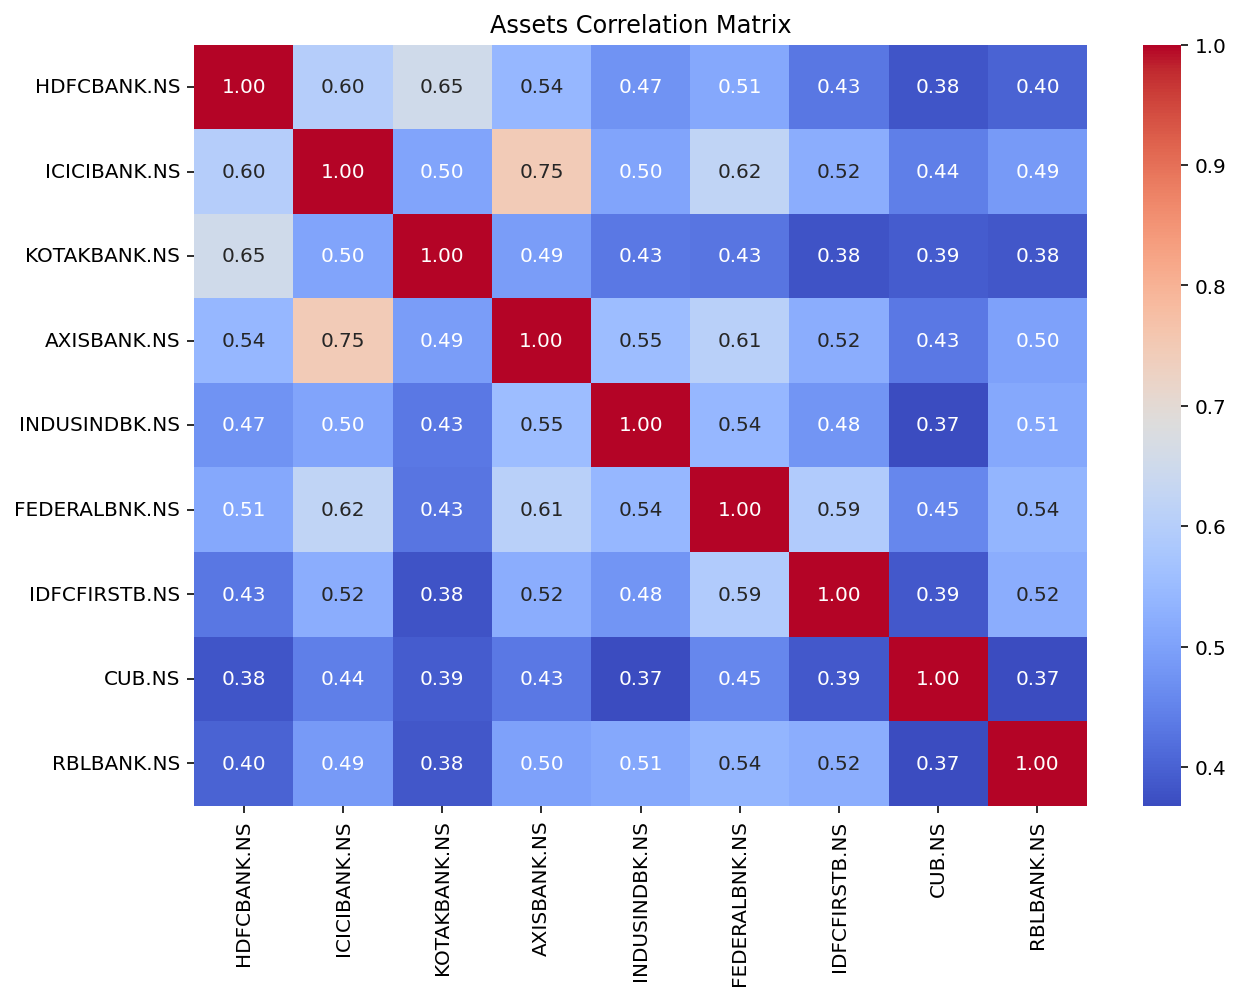

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HDFCBANK.NS', 'KOTAKBANK.NS'), ('AXISBANK.NS', 'CUB.NS'), ('FEDERALBNK.NS', 'IDFCFIRSTB.NS')]


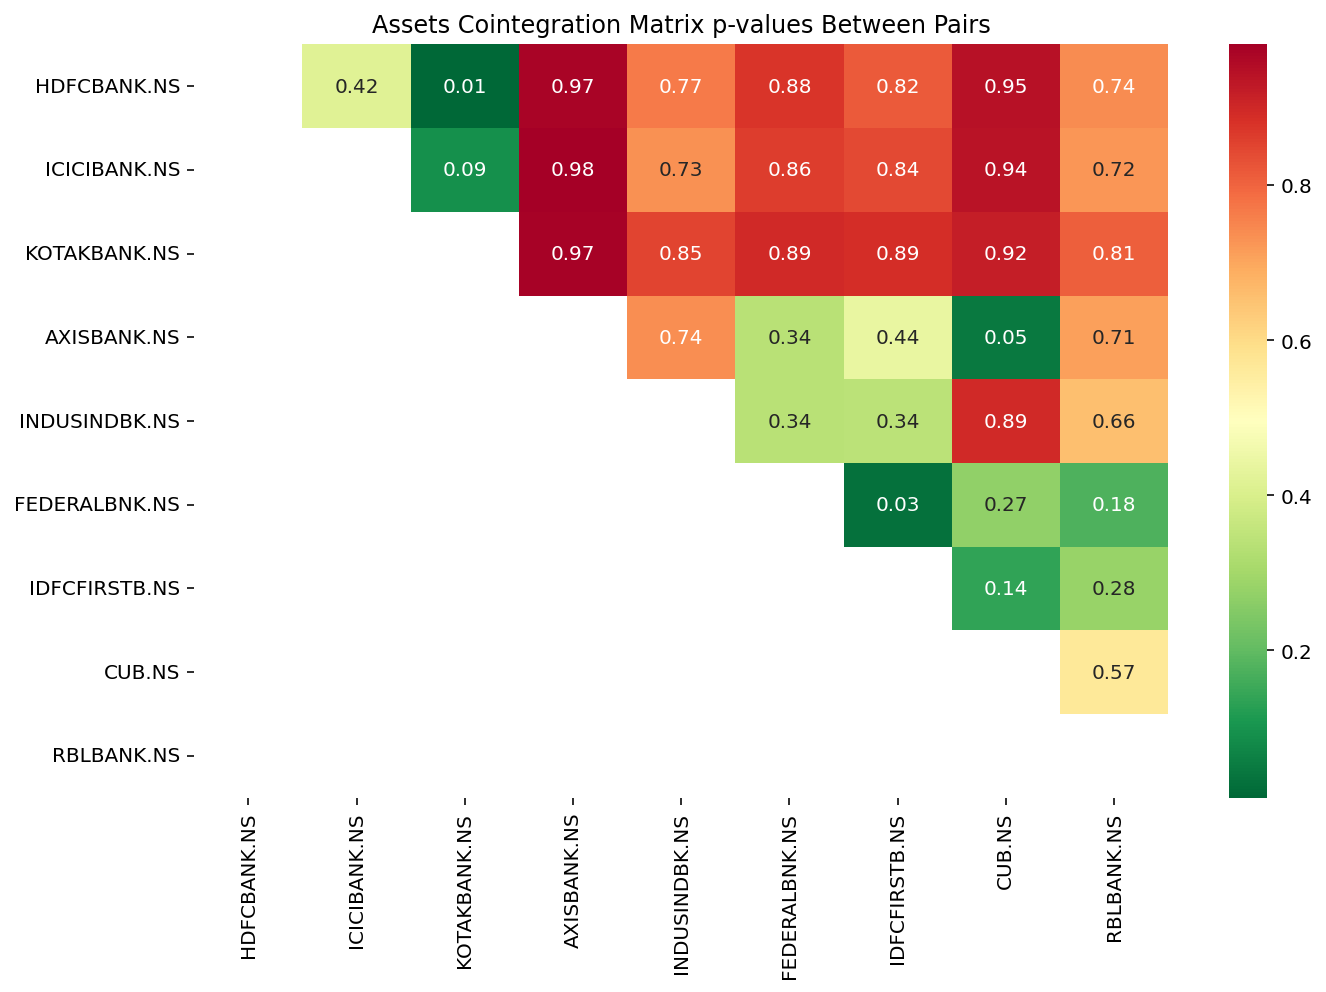

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'FEDERALBNK.NS'
asset2 = 'IDFCFIRSTB.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

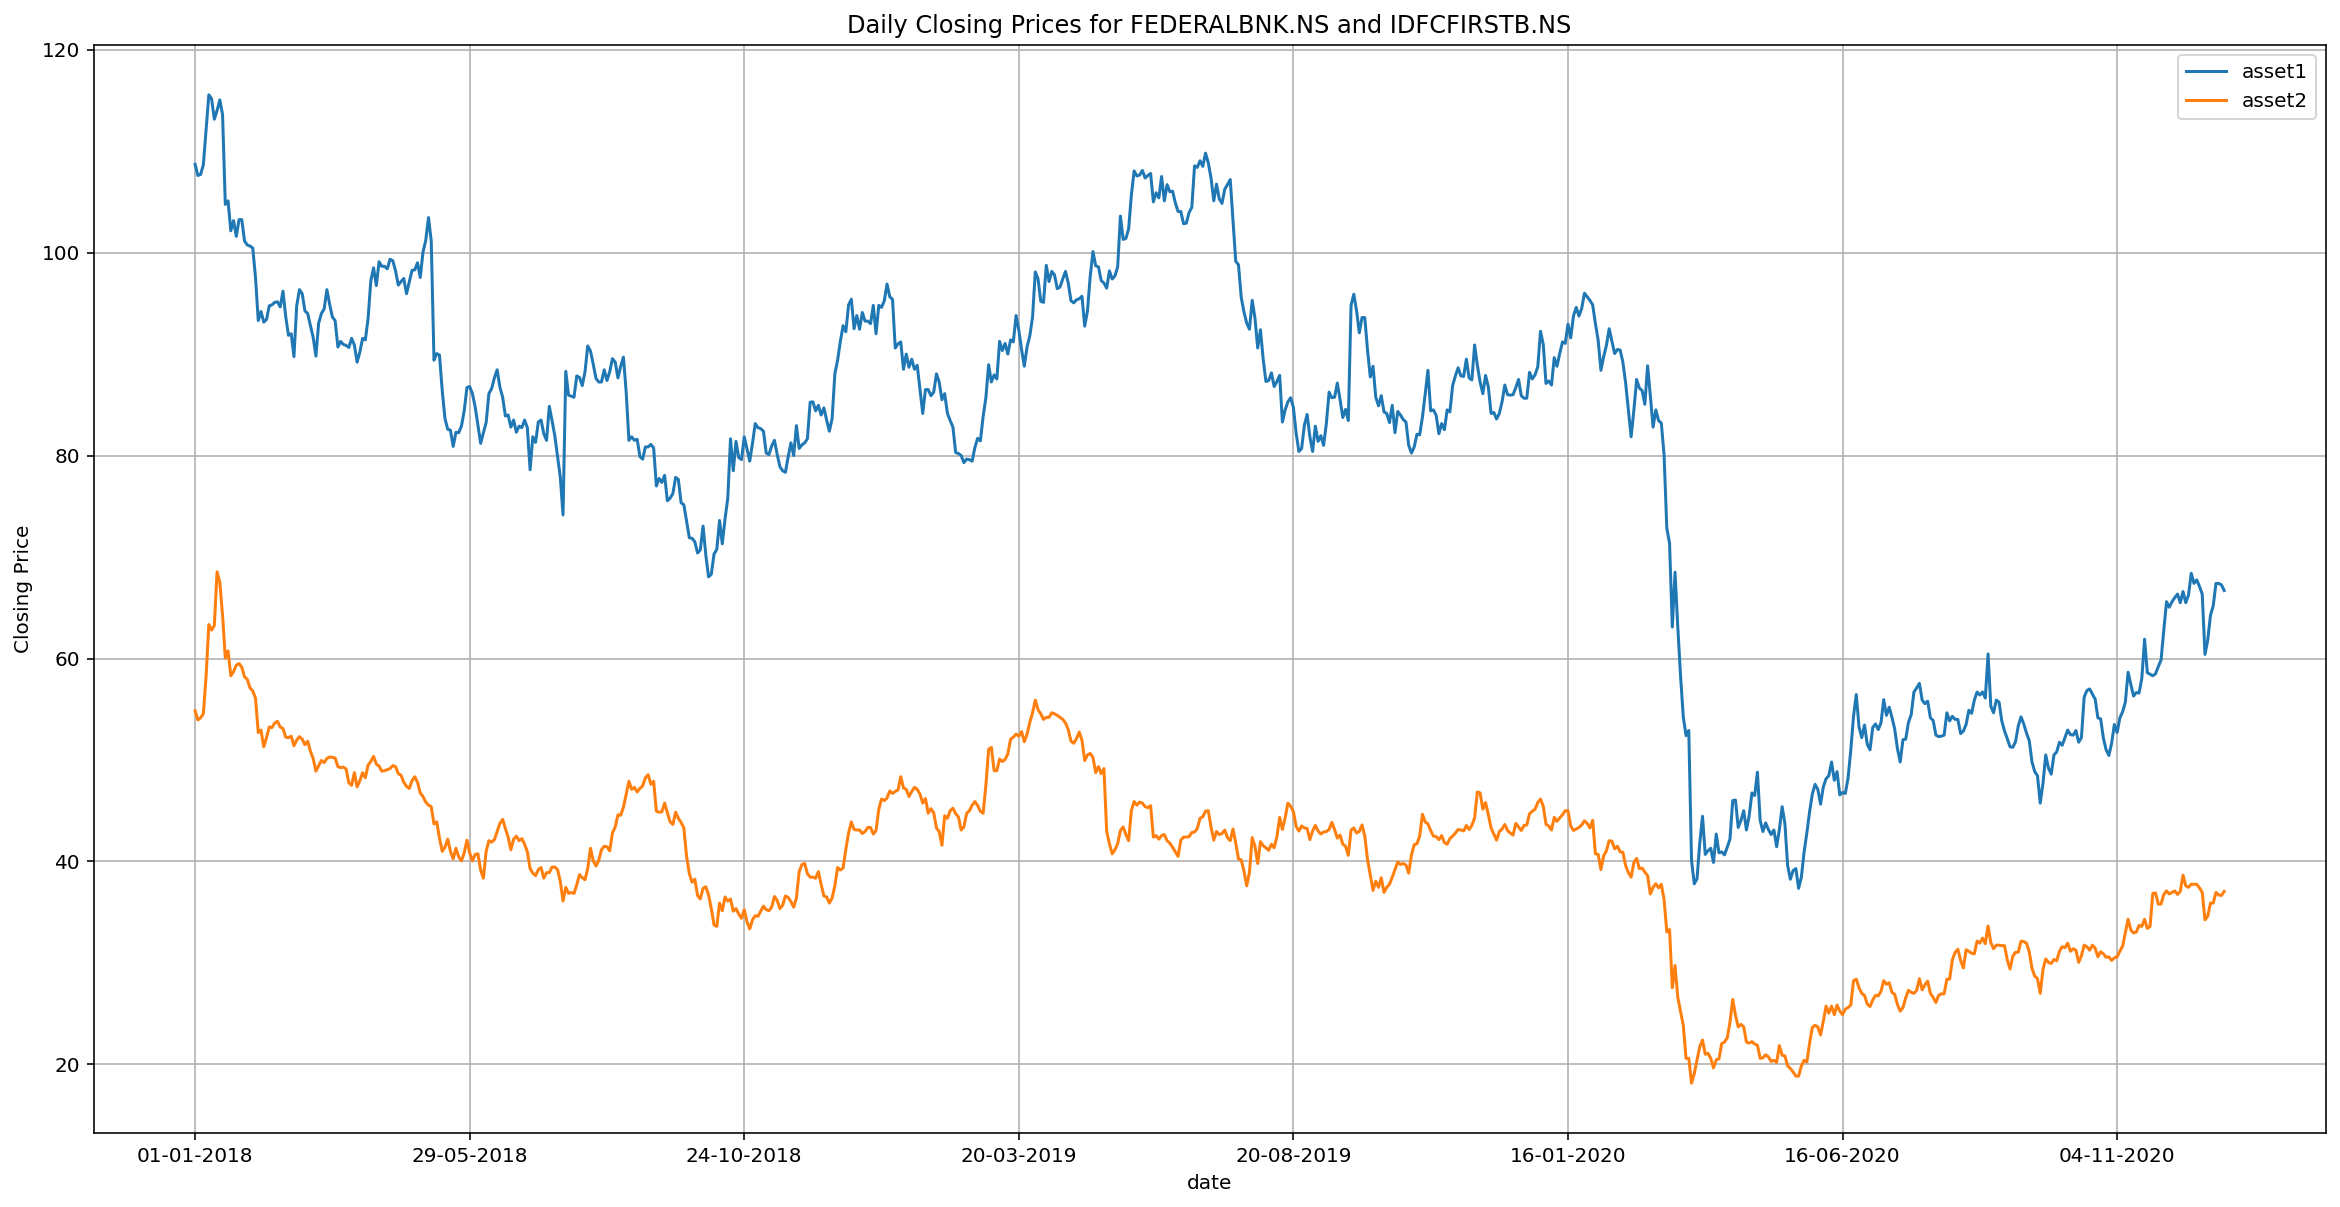

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          6.193e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:21:43   Log-Likelihood:                         -2153.7
No. Observations:                 740   AIC:                                      4309.
Df Residuals:                     739   BIC:                                      4314.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.4979      0.002    248.864      0.000       0.494       0.502
==============================================================================
Omnibus:                       23.476   Durbin-Watson:                   0.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.399
Skew:                          -0.424   Prob(JB):                     5.03e-06
Kurtosis:                       2.732   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

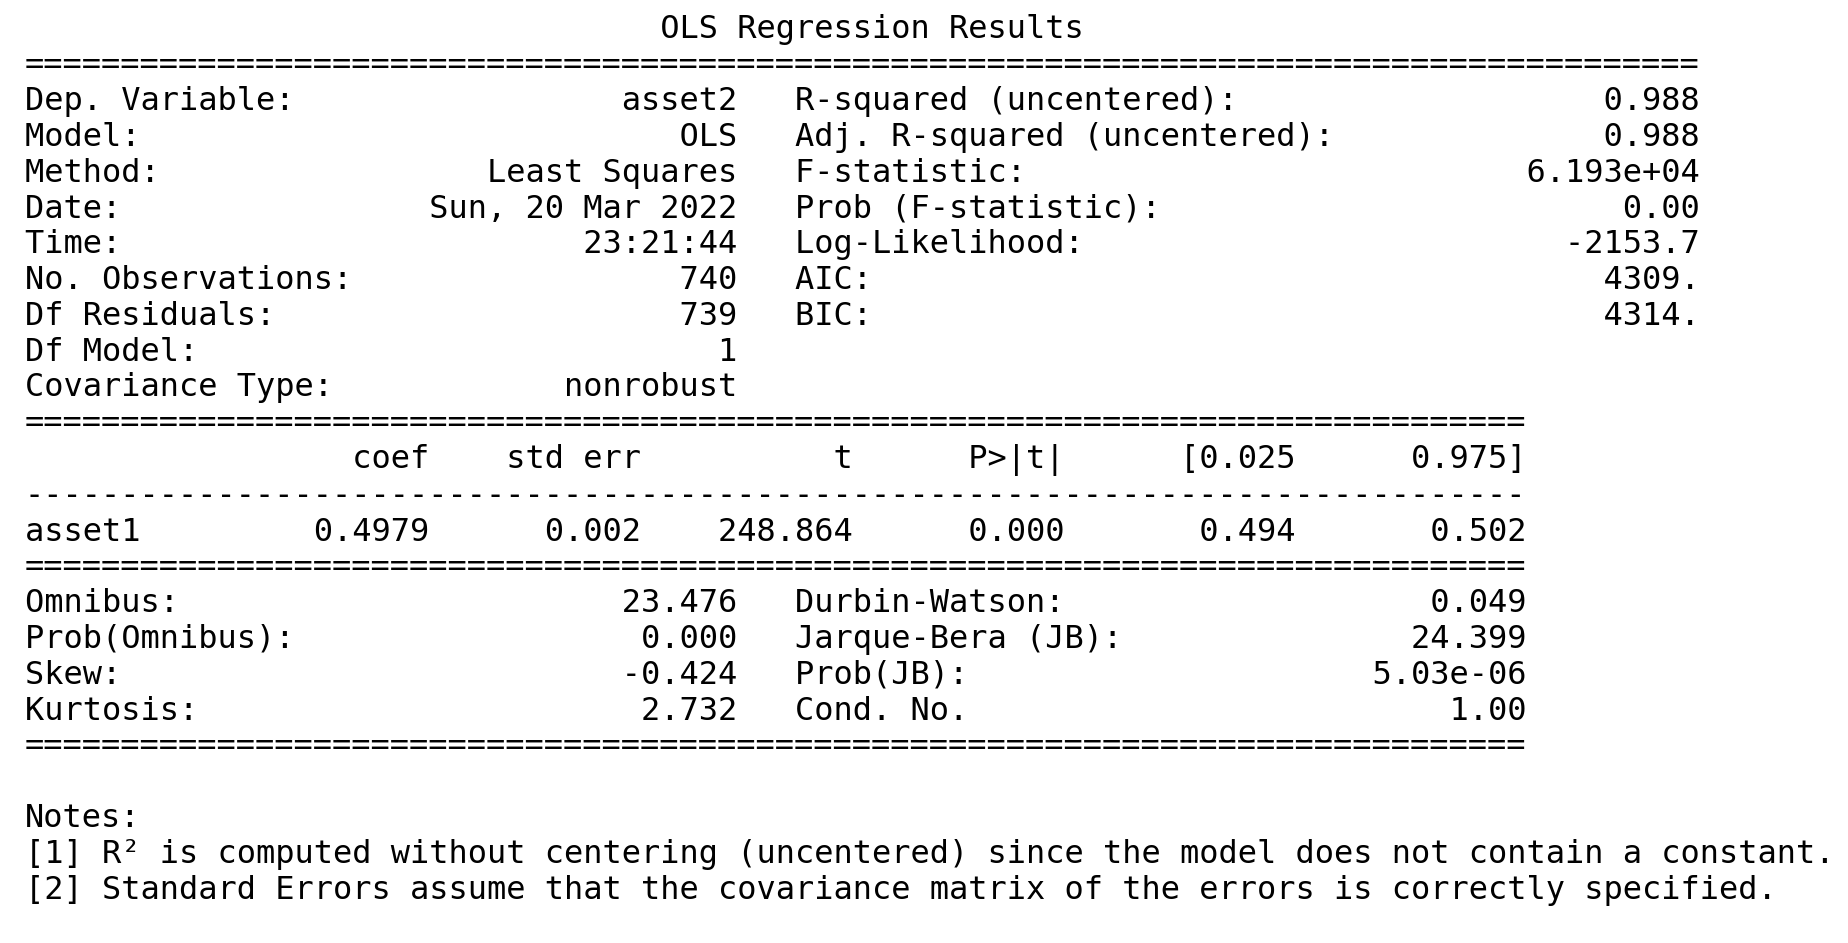

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.497885271221374


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

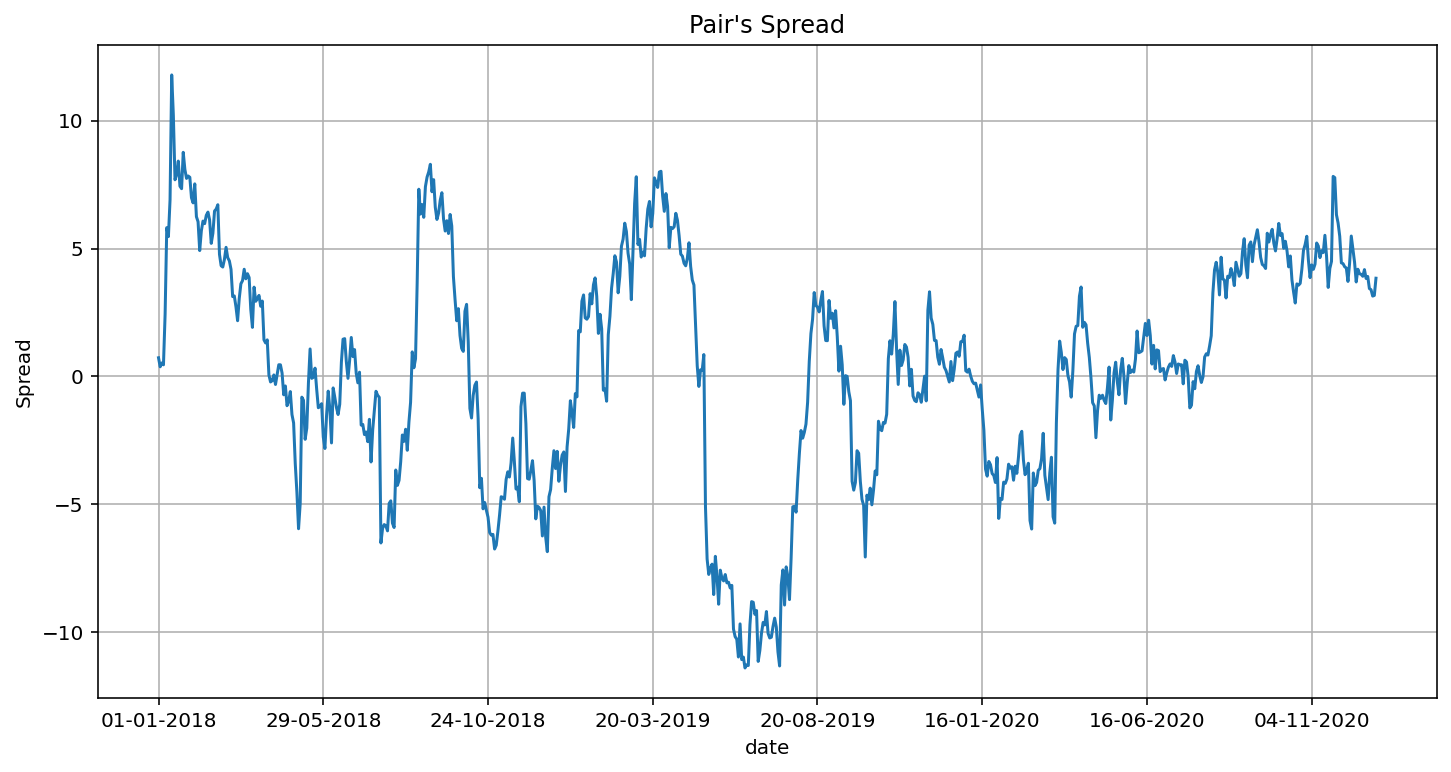

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.969417068634568,
 0.037850856114865356,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 2062.553385686009)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.969417068634568


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1     asset2
date                            
01-01-2021  68.050003  37.400002
04-01-2021  70.550003  38.599998
05-01-2021  72.300003  39.700001
06-01-2021  72.699997  41.400002
07-01-2021  75.650002  45.799999

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1     asset2         z  z upper limit  z lower limit
date                                                                    
01-01-2021  68.050003  37.400002  0.868763            1.0           -1.0
04-01-2021  70.550003  38.599998  0.908064            1.0           -1.0
05-01-2021  72.300003  39.700001  0.876622            1.0           -1.0
06-01-2021  72.699997  41.400002  0.564577            1.0           -1.0
07-01-2021  75.650002  45.799999  0.064831            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

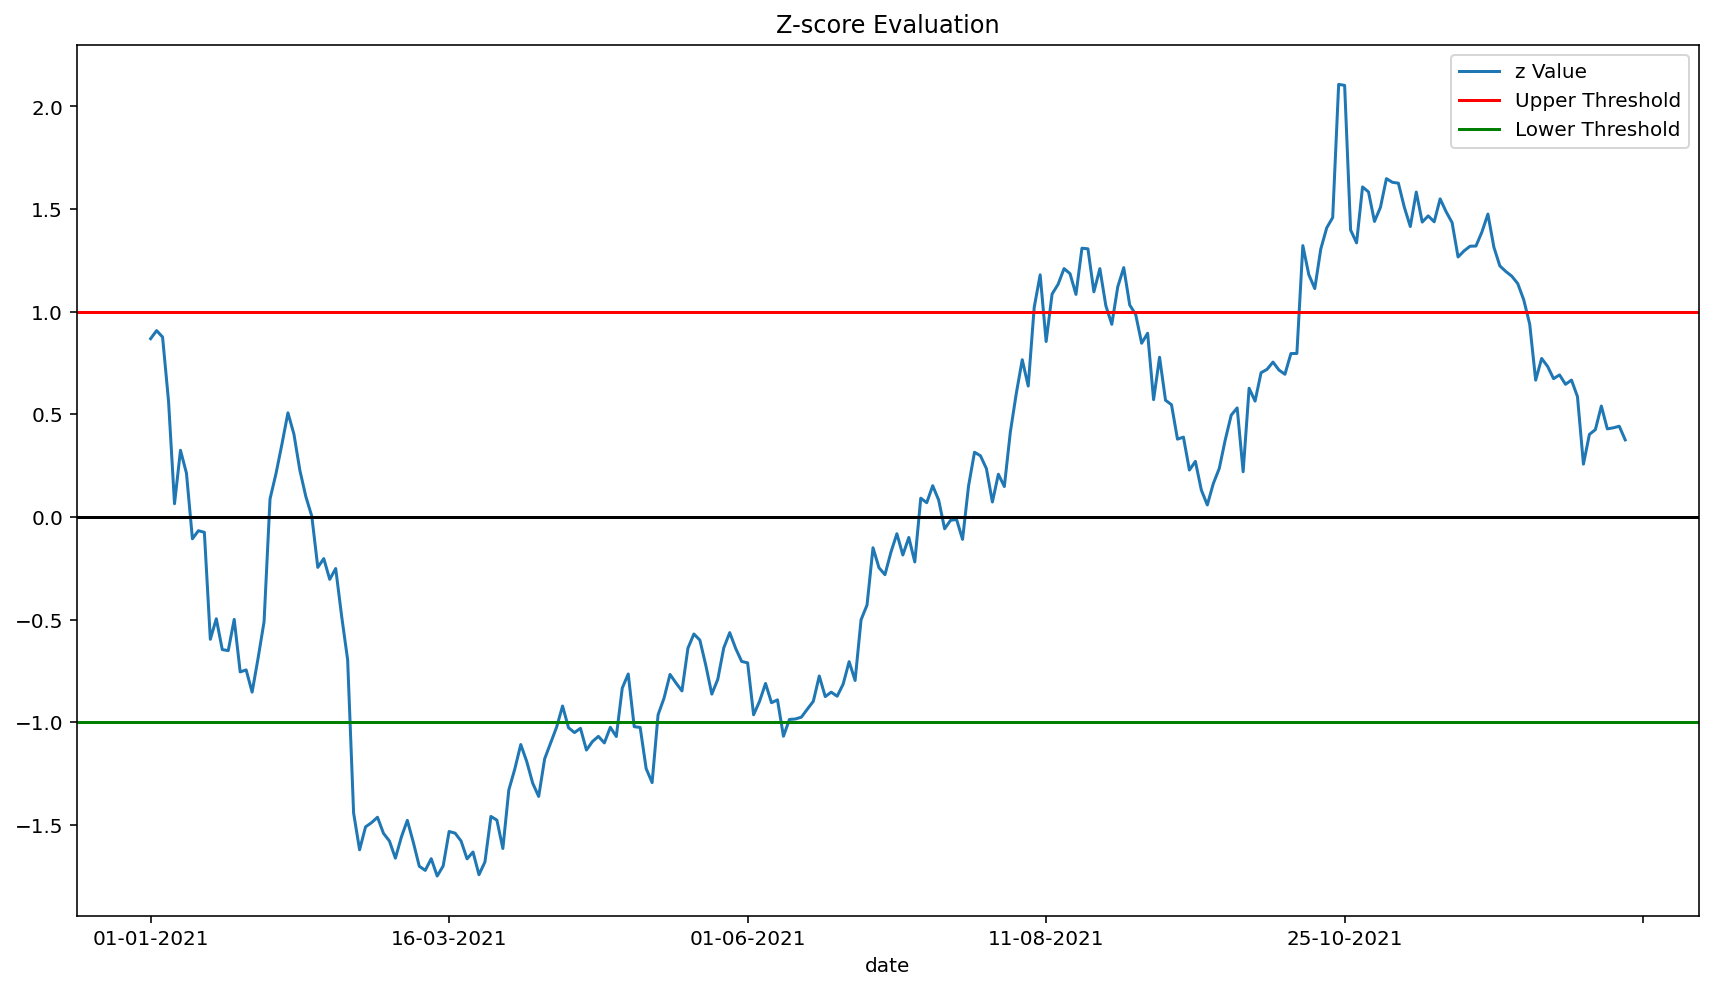

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  68.050003  37.400002  0.868763            1.0           -1.0   
04-01-2021  70.550003  38.599998  0.908064            1.0           -1.0   
05-01-2021  72.300003  39.700001  0.876622            1.0           -1.0   
29-12-2021  81.949997  47.400002  0.434548            1.0           -1.0   
30-12-2021  82.199997  47.500000  0.442327            1.0           -1.0   
31-12-2021  83.000000  48.349998  0.375832            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
19-02-2021  83.449997  62.400002 -1.441751            1.0           -1.0   
22-02-2021  79.949997  61.500000 -1.620676            1.0           -1.0   
23-02-2021  81.250000  61.400002 -1.509075            1.0           -1.0   
24-02-2021  84.699997  63.799999 -1.488488            1.0           -1.0   
25-02-2021  86.250000  64.699997 -1.462183            1.0           -1.0   
26-02-2021  83.550003  63.450001 -1.540246            1.0           -1.0   
01-03-2021  83.050003  63.450001 -1.578006            1.0           -1.0   
02-03-2021  83.300003  64.500000 -1.661536            1.0           -1.0   
03-03-2021  88.099998  67.099998 -1.558546            1.0           -1.0   
04-03-2021  90.699997  68.199997 -1.477343            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
19-02-2021         1         1.0        -1        -1.0  
22-02-2021         1         0.0        -1         0.0  
23-02-2021         1         0.0        -1         0.0  
24-02-2021         1         0.0        -1         0.0  
25-02-2021         1         0.0        -1         0.0  
26-02-2021         1         0.0        -1         0.0  
01-03-2021         1         0.0        -1         0.0  
02-03-2021         1         0.0        -1         0.0  
03-03-2021         1         0.0        -1         0.0  
04-03-2021         1         0.0        -1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  68.050003  37.400002  0.868763            1.0           -1.0   
19-02-2021  83.449997  62.400002 -1.441751            1.0           -1.0   
15-04-2021  75.849998  52.450001 -0.920404            1.0           -1.0   
16-04-2021  76.400002  53.650002 -1.026276            1.0           -1.0   
30-04-2021  80.099998  54.700001 -0.833136            1.0           -1.0   
27-08-2021  77.949997  42.500000  0.938718            1.0           -1.0   
30-08-2021  81.349998  43.450001  1.121523            1.0           -1.0   
02-09-2021  82.800003  44.900002  0.986542            1.0           -1.0   
13-10-2021  93.599998  48.900002  1.322029            1.0           -1.0   
09-12-2021  90.800003  49.500000  0.939801            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
19-02-2021         1         1.0        -1        -1.0  
15-04-2021         0        -1.0         0         1.0  
16-04-2021         1         1.0        -1        -1.0  
30-04-2021         0        -1.0         0         1.0  
27-08-2021         0         1.0         0        -1.0  
30-08-2021        -1        -1.0         1         1.0  
02-09-2021         0         1.0         0        -1.0  
13-10-2021        -1        -1.0         1         1.0  
09-12-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

83.449997    1
76.400002    1
79.449997    1
84.500000    1
85.199997    1
77.949997    1
82.800003    1
90.800003    1
Name: asset1, dtype: int64

In [32]:
signals

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  68.050003  37.400002  0.868763            1.0           -1.0   
04-01-2021  70.550003  38.599998  0.908064            1.0           -1.0   
05-01-2021  72.300003  39.700001  0.876622            1.0           -1.0   
06-01-2021  72.699997  41.400002  0.564577            1.0           -1.0   
07-01-2021  75.650002  45.799999  0.064831            1.0           -1.0   
...               ...        ...       ...            ...            ...   
27-12-2021  81.250000  46.400002  0.540805            1.0           -1.0   
28-12-2021  81.900002  47.400002  0.429494            1.0           -1.0   
29-12-2021  81.949997  47.400002  0.434548            1.0           -1.0   
30-12-2021  82.199997  47.500000  0.442327            1.0           -1.0   
31-12-2021  83.000000  48.349998  0.375832            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         0         NaN         0         NaN  
04-01-2021         0         0.0         0         0.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

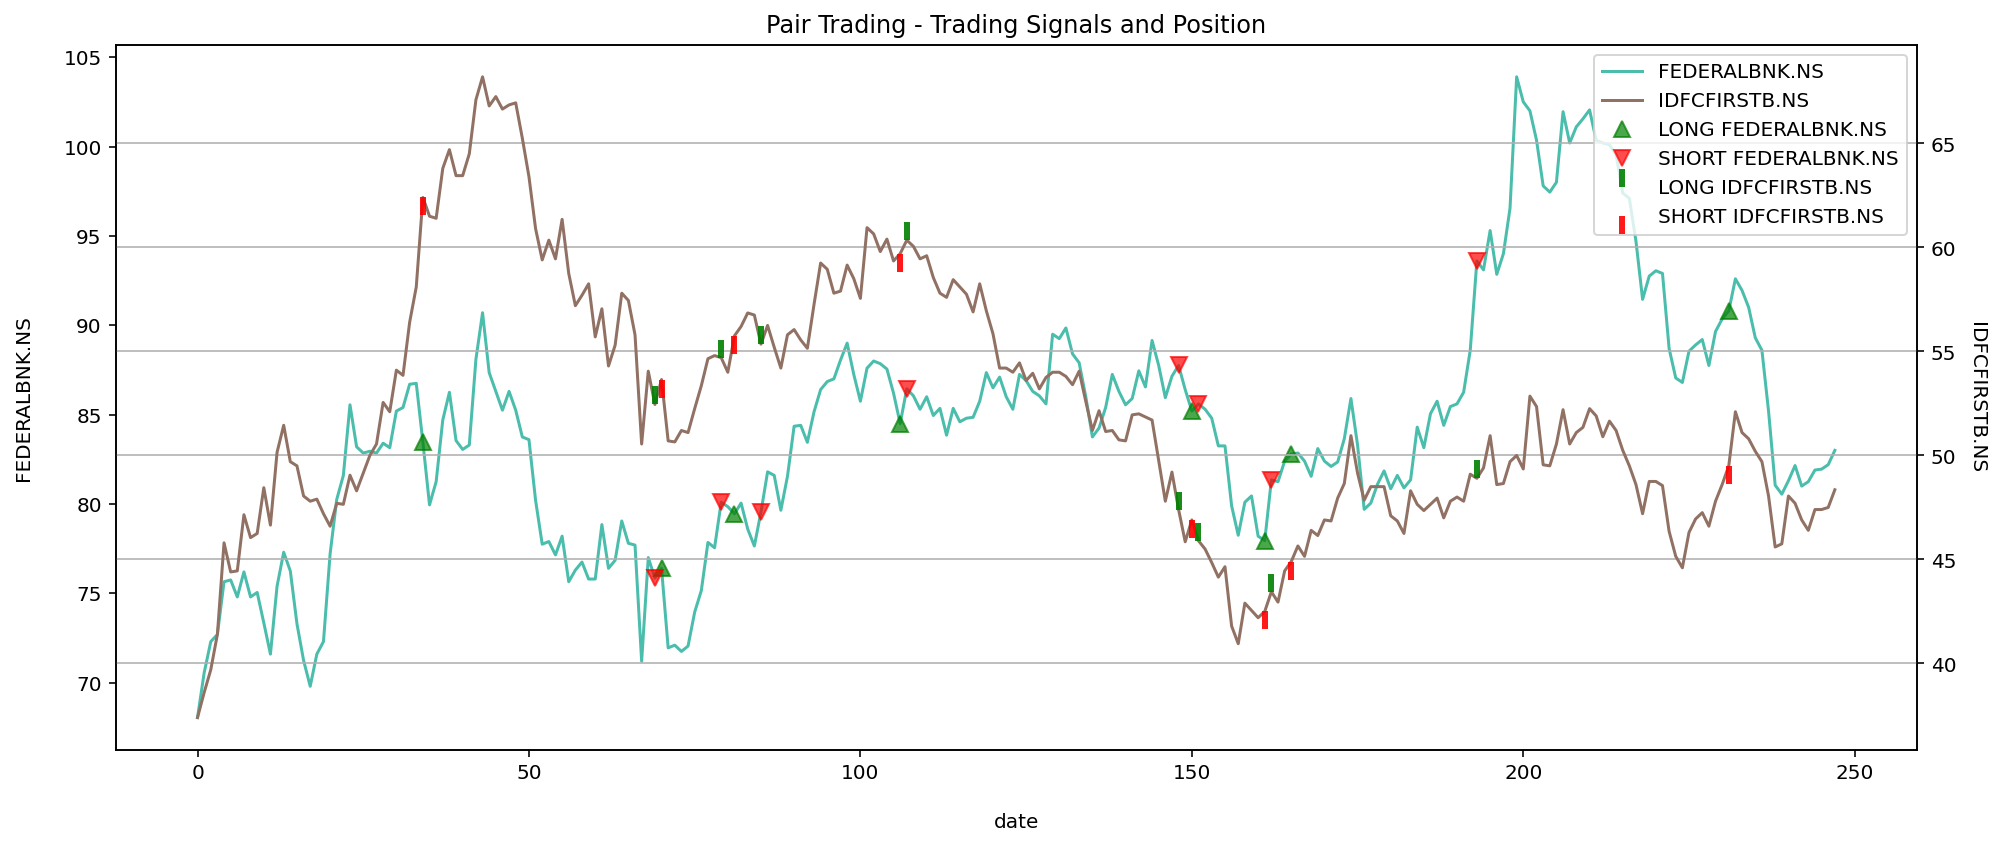

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  positions1
0    68.050003        NaN            NaN            NaN      NaN         NaN
1    70.550003        0.0  100000.000000  100000.000000      NaN         0.0
2    72.300003        0.0  100000.000000  100000.000000      0.0         0.0
3    72.699997        0.0  100000.000000  100000.000000      0.0         0.0
4    75.650002        0.0  100000.000000  100000.000000      0.0         0.0
243  81.250000        0.0  109331.397037  109331.397037      0.0         0.0
244  81.900002        0.0  109331.397037  109331.397037      0.0         0.0
245  81.949997        0.0  109331.397037  109331.397037      0.0         0.0
246  82.199997        0.0  109331.397037  109331.397037      0.0         0.0
247  83.000000        0.0  109331.397037  109331.397037      0.0         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1         cash1   total asset1   return1  positions1
0   68.050003           NaN           NaN            NaN       NaN         NaN
34  83.449997  80278.897066  19721.102934  100000.000000  0.000000         1.0
69  75.849998      0.000000  92688.801462   92688.801462 -0.011795        -1.0
70  76.400002  73496.801472  19191.999990   92688.801462  0.000000         1.0
79  80.099998      0.000000  96248.198519   96248.198519  0.026154        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1  holdings1          cash1   total asset1  return1  positions1  \
0    68.050003        NaN            NaN            NaN      NaN         NaN   
1    70.550003        0.0  100000.000000  100000.000000      NaN         0.0   
2    72.300003        0.0  100000.000000  100000.000000      0.0         0.0   
3    72.699997        0.0  100000.000000  100000.000000      0.0         0.0   
4    75.650002        0.0  100000.000000  100000.000000      0.0         0.0   
243  81.250000        0.0  109331.397037  109331.397037      0.0         0.0   
244  81.900002        0.0  109331.397037  109331.397037      0.0         0.0   
245  81.949997        0.0  109331.397037  109331.397037      0.0         0.0   
246  82.199997        0.0  109331.397037  109331.397037      0.0         0.0   
247  83.000000        0.0  109331.397037  109331.397037      0.0         0.0   

        asset2  holdings2          cash2   total asset2  return2  positions2  
0    37.400002        NaN            NaN            NaN      NaN         NaN  
1    38.599998        0.0  100000.000000  100000.000000      NaN         0.0  
2    39.700001        0.0  100000.000000  100000.000000      0.0         0.0  
3    41.400002        0.0  100000.000000  100000.000000      0.0         0.0  
4    45.799999        0.0  100000.000000  100000.000000      0.0         0.0  
243  46.400002        0.0  109968.804501  109968.804501      0.0         0.0  
244  47.400002        0.0  109968.804501  109968.804501      0.0         0.0  
245  47.400002        0.0  109968.804501  109968.804501      0.0         0.0  
246  47.500000        0.0  109968.804501  109968.804501      0.0         0.0  
247  48.349998        0.0  109968.804501  109968.804501      0.0         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1         cash1   total asset1   return1  \
0   68.050003           NaN           NaN            NaN       NaN   
34  83.449997  80278.897066  19721.102934  100000.000000  0.000000   
69  75.849998      0.000000  92688.801462   92688.801462 -0.011795   
70  76.400002  73496.801472  19191.999990   92688.801462  0.000000   
79  80.099998      0.000000  96248.198519   96248.198519  0.026154   

    positions1     asset2     holdings2          cash2   total asset2  \
0          NaN  37.400002           NaN            NaN            NaN   
34         1.0  62.400002 -91478.402243  191478.402243  100000.000000   
69        -1.0  52.450001      0.000000  114586.701129  114586.701129   
70         1.0  53.650002 -78650.902243  193237.603372  114586.701129   
79        -1.0  54.700001      0.000000  113047.402258  113047.402258   

     return2  positions2  
0        NaN         NaN  
34  0.000000        -1.0  
69  0.020898         1.0  
70  0.000000        -1.0  
79  0.001298         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

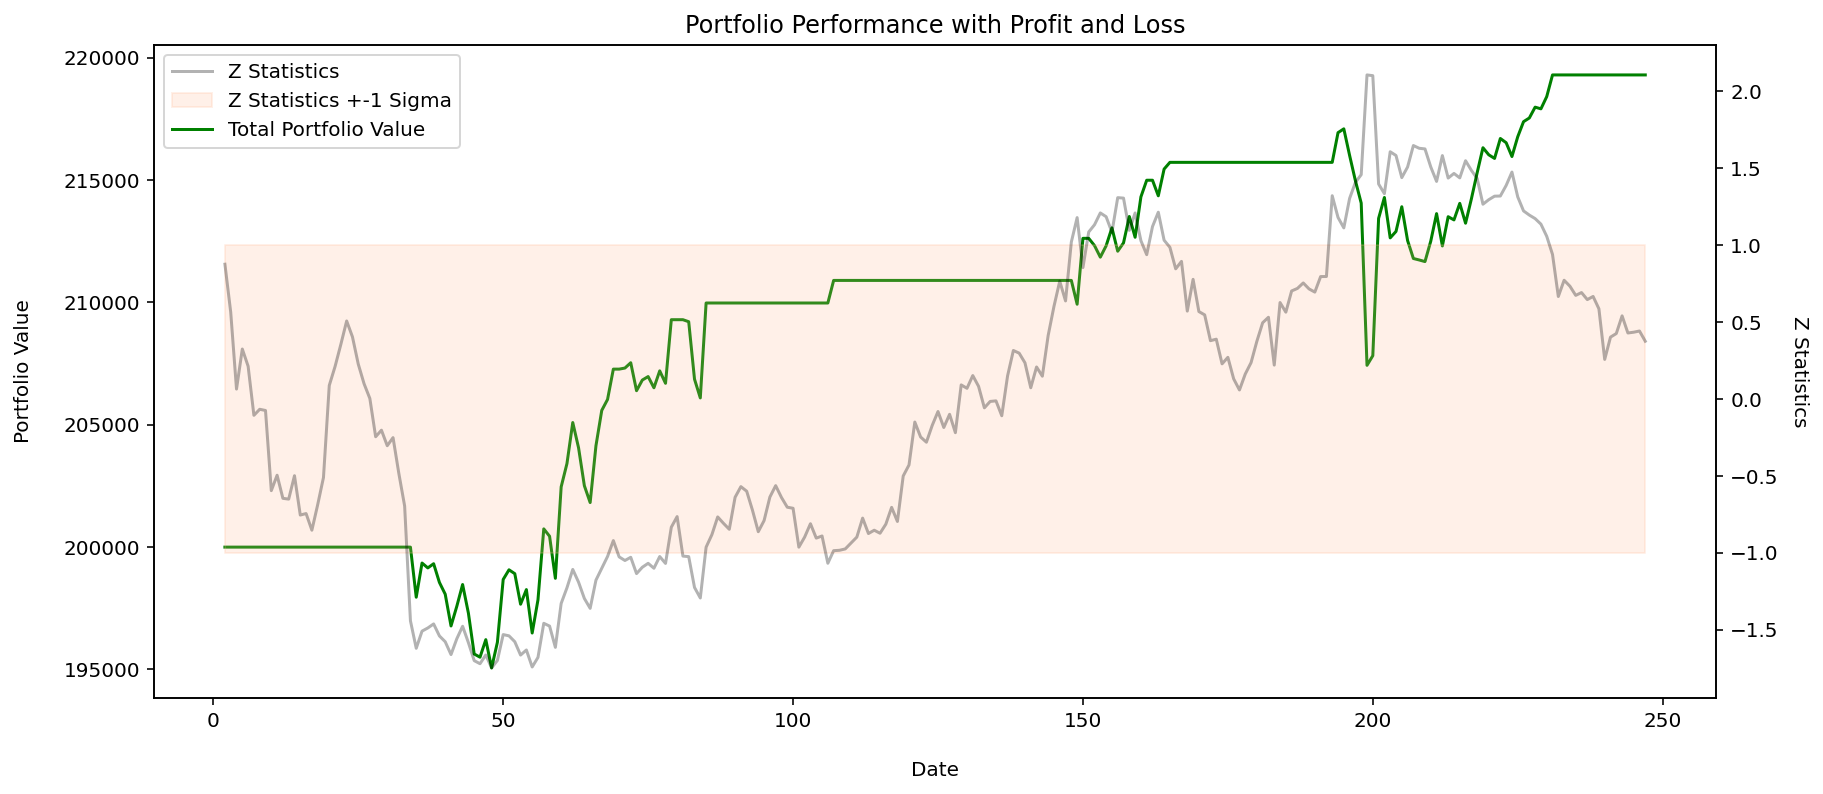

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

219300.20153765994

In [48]:
profit = final_portfolio - 2*initial_capital
profit

19300.201537659945

In [49]:
roi = (profit/(2*initial_capital))*100
roi

9.650100768829972

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 222.165%
